## Market1501 / cuhk03 

{'UMPM': {'password': 'ahJaka4o', 'username': 'umpmuser'},
 'data_root': '/home/DATA'}



Using TensorFlow backend.


/home/DATA/cuhk03_release found :)
/home/DATA/Market-1501-v15.09.15 found :)
/home/DATA/DukeMTMC-reID found :)
found memmaped /home/DATA/cuhk03_release/labeled64x128.npy
(cuhk) positive test pairs: 9290
(cuhk) positive train pairs: 127242
(market) positive test pairs:  300631
(market) positive train pairs:  309874
load memmap /home/DATA/DukeMTMC-reID/bounding_box_test128x64.npy
load memmap /home/DATA/DukeMTMC-reID/bounding_box_train128x64.npy
(duke) positive test pairs:  926089
(duke) positive train pairs:  749270
(12, 128, 64, 6)
is same: [0 1]
is same: [1 0]
is same: [0 1]
is same: [0 1]
is same: [1 0]
is same: [0 1]
is same: [1 0]
is same: [0 1]
is same: [1 0]
is same: [1 0]
is same: [0 1]
is same: [1 0]


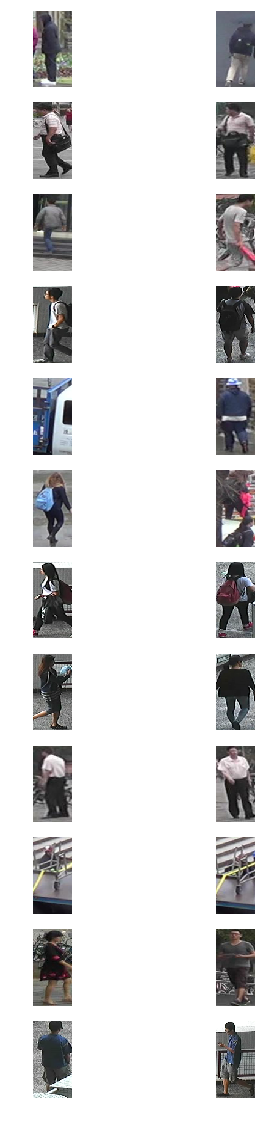

In [1]:
%matplotlib inline
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
print('')
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from reid.stacknet import get_model
from reid.data import DataSampler

from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from os.path import join, isfile, isdir, exists, splitext

root = Settings['data_root']

# target_w = 221
# target_h = 221
target_w = 64
target_h = 128


sampler = DataSampler(root, target_w, target_h)

npos = 6
nneg = 6
x, y = sampler.get_test_batch(npos, nneg)
#n = npos + nneg
n = len(x)
print(x.shape)

fig = plt.figure(figsize=(6, 20))
for pid in range(n):
    print('is same:', y[pid])
    im = x[pid]
    ax = fig.add_subplot(n, 2, pid*2+1); ax.axis('off')
    ax.imshow(im[:,:,0:3])
    ax = fig.add_subplot(n, 2, pid*2+2); ax.axis('off')
    ax.imshow(im[:,:,3:6])
plt.show()

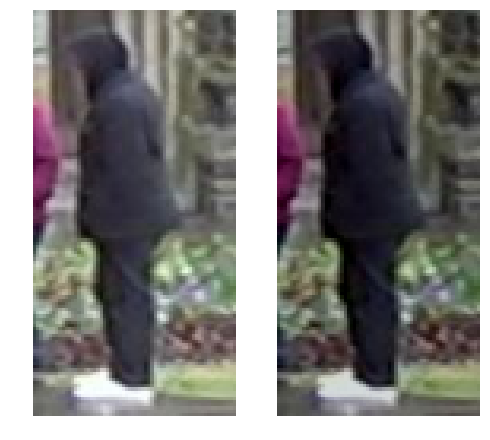

In [2]:
#def random_
import numpy as np
from numpy.random import uniform

def random_contrast_brightness(im):
    """
    """
    alpha = uniform(0.5, 3)
    beta = uniform(-50, 50)
    return np.clip(alpha * im + beta, 0, 255).astype('uint8')
    

im1 = x[0, :, :, 0:3]

im2 = random_contrast_brightness(im1)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(121); ax.axis('off')
ax.imshow(im1)

ax = fig.add_subplot(122); ax.axis('off')
ax.imshow(im2)

plt.show()

## UMPM dataset

/home/DATA
UMPM
elapsed 0.023783445358276367
same [1 0]
(32, 128, 64, 6)


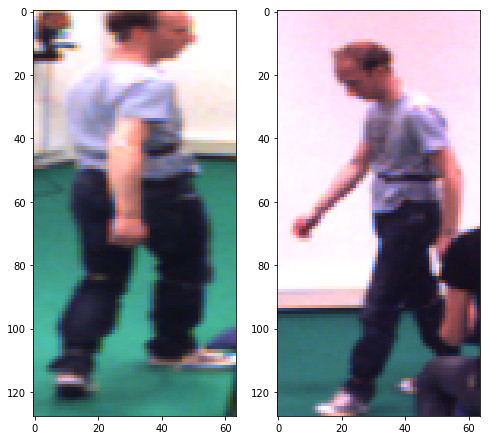

In [3]:
from time import time
from reid.data import UMPMSampler

root = Settings['data_root']
print(root)

user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
umpm_sampler = UMPMSampler(root, ['p2_chair_2'], user, pwd, target_w, target_h)


_start = time()
x, y = umpm_sampler.get_train()
_end = time()
print('elapsed', _end - _start)

print('same', y[0])

print(x.shape)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(121)
ax.imshow(x[0, :, :, 0:3].astype('uint8'))
ax = fig.add_subplot(122)
ax.imshow(x[0, :, :, 3:6].astype('uint8'))
plt.show()

## MOT16 dataset

/home/DATA/MOT16 found :)
MOT16: load memmapped file /home/DATA/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded
(MOT16) total number of bounding boxes: 1736
elapsed 0.015181541442871094
same [1 0]


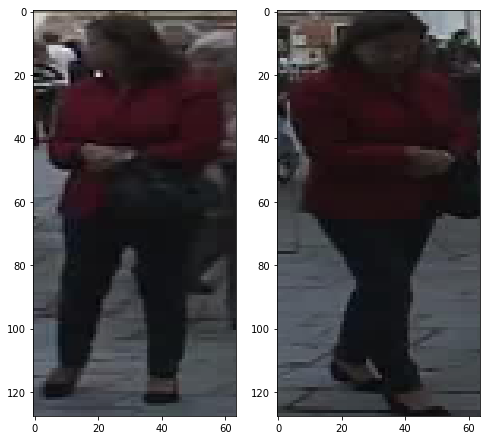

In [4]:
from reid.data import MOT16Sampler

mot_sampler = MOT16Sampler(root, target_w, target_h)


_start = time()
x, y = mot_sampler.sample()
_end = time()
print('elapsed', _end - _start)

print('same', y[0])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(121)
ax.imshow(x[0,:,:,0:3].astype('uint8'))
ax = fig.add_subplot(122)
ax.imshow(x[0,:,:,3:6].astype('uint8'))
plt.show()

/home/DATA/MOT16 found :)
MOT16: load memmapped file /home/DATA/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded
(MOT16) total number of bounding boxes: 1736
UMPM
/home/DATA/cuhk03_release found :)
/home/DATA/Market-1501-v15.09.15 found :)
/home/DATA/DukeMTMC-reID found :)
found memmaped /home/DATA/cuhk03_release/labeled64x128.npy
(cuhk) positive test pairs: 9290
(cuhk) positive train pairs: 127242
(market) positive test pairs:  300631
(market) positive train pairs:  309874
load memmap /home/DATA/DukeMTMC-reID/bounding_box_test128x64.npy
load memmap /home/DATA/DukeMTMC-reID/bounding_box_train128x64.npy
(duke) positive test pairs:  926089
(duke) positive train pairs:  749270
------------


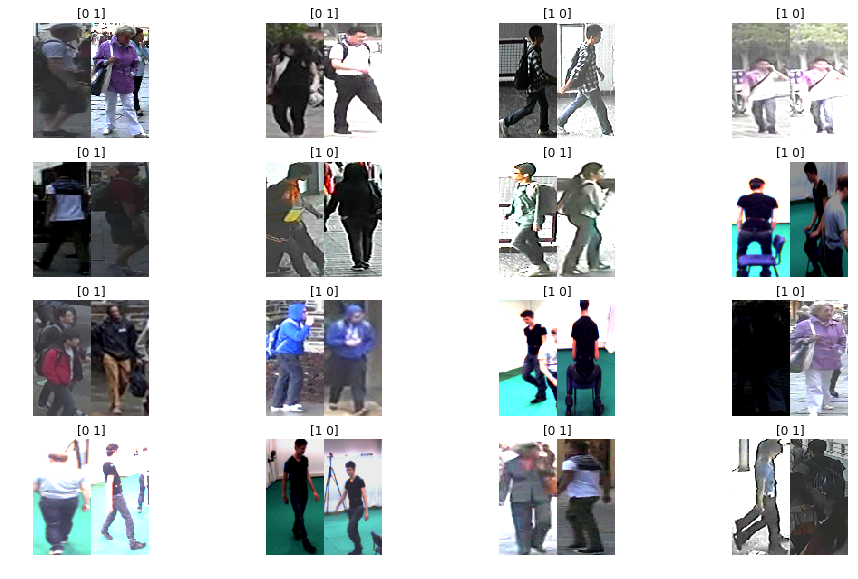

In [5]:
from reid.data import Data
import numpy as np
root = Settings['data_root']
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']


sampler = Data(root, target_w, target_h, user, pwd)
print('------------')


x, y = sampler.train()

fig = plt.figure(figsize=(16,20))
for idx, im in enumerate(x):
    ax = fig.add_subplot(8, 4, idx+1); ax.axis('off')
    Im = np.concatenate([im[:,:,0:3], im[:,:,3:6]], axis=1).astype('uint8')
    ax.imshow(Im)
    ax.set_title(str(y[idx]))
    
plt.show()

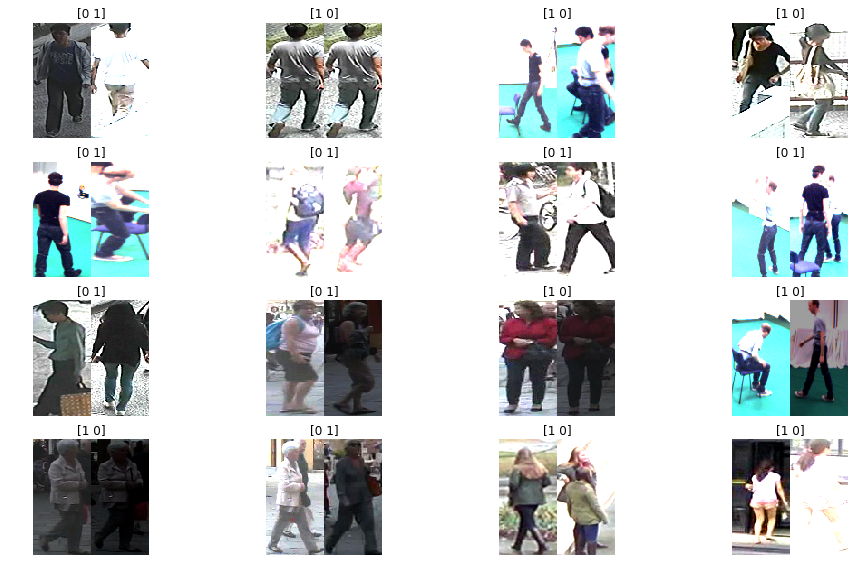

In [6]:
x, y = sampler.train()

fig = plt.figure(figsize=(16,20))
for idx, im in enumerate(x):
    ax = fig.add_subplot(8, 4, idx+1); ax.axis('off')
    Im = np.concatenate([im[:,:,0:3], im[:,:,3:6]], axis=1).astype('uint8')
    ax.imshow(Im)
    ax.set_title(str(y[idx]))
    
plt.show()

y: 1


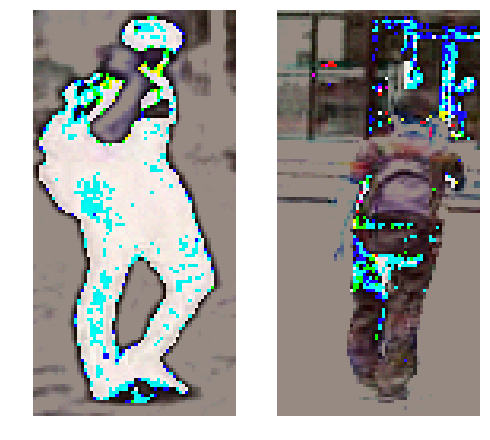

In [7]:
#from keras.applications.densenet import preprocess_input
from keras.applications.vgg16 import preprocess_input

def generate_training():
    global sampler
    while True:
        X, Y = sampler.train(add_noise=True)
        X = X
        X_a = preprocess_input(X[:,:,:,0:3])
        X_b = preprocess_input(X[:,:,:,3:6])
        X_ = np.concatenate([X_a, X_b], axis=3)
        yield X_/255, Y[:, 0]
        
def generate_test():
    global sampler
    while True:
        X, Y = sampler.test()
        X = X
        X_a = preprocess_input(X[:,:,:,0:3])
        X_b = preprocess_input(X[:,:,:,3:6])
        X_ = np.concatenate([X_a, X_b], axis=3)
        yield X_/255, Y[:, 0]

        
# ------------------------
gen = generate_training()

X, Y = next(gen)
Xa = X[:,:,:,0:3]
Xb = X[:,:,:,3:6]

i = 0
print("y:", Y[i])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(121); ax.axis("off")
ax.imshow(Xa[i])
ax = fig.add_subplot(122); ax.axis("off")
ax.imshow(Xb[i])

plt.show()

In [8]:
np.min(Xa)

-0.4850196078431373

In [ ]:
from reid.stacknet import get_model
from keras.models import load_model
from keras.optimizers import SGD, RMSprop, Nadam

opt = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
opt = Nadam(lr=0.00001)

filepath = join(root, 'model_128x64.h5')

if isfile(filepath):
    model = load_model(filepath)
else:
    model = get_model(w=128, h=64)
    model.summary()

    
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['binary_accuracy', 'acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 64, 64)       3520      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 64, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 16, 256)       295168    
__________

## Training

In [ ]:
from keras.callbacks import ModelCheckpoint, TerminateOnNaN

checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint, TerminateOnNaN()]

history = model.fit_generator(generate_training(), 
                             validation_data=generate_test(),
                             validation_steps=5,
                             steps_per_epoch=100,
                             epochs=50,
        
                             callbacks=callbacks_list)

acc = history.history['val_binary_accuracy']
tacc = history.history['binary_accuracy']

plt.plot(range(len(acc)), acc)
plt.plot(range(len(tacc)), tacc)
plt.show()

Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 0.7792 - binary_accuracy: 0.5133 - acc: 0.5133
Epoch 00001: loss improved from inf to 0.77821, saving model to /home/DATA/model_128x64.h5
100/100 [==============================] - 10s 101ms/step - loss: 0.7782 - binary_accuracy: 0.5138 - acc: 0.5138 - val_loss: 0.6938 - val_binary_accuracy: 0.4875 - val_acc: 0.4875
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 0.7316 - binary_accuracy: 0.5486 - acc: 0.5486
Epoch 00002: loss improved from 0.77821 to 0.73307, saving model to /home/DATA/model_128x64.h5
100/100 [==============================] - 8s 79ms/step - loss: 0.7331 - binary_accuracy: 0.5469 - acc: 0.5469 - val_loss: 0.6643 - val_binary_accuracy: 0.6250 - val_acc: 0.6250
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 0.7195 - binary_accuracy: 0.5297 - acc: 0.5297
Epoch 00003: loss improved from 0.73307 to 0.71959, saving model to /home/DATA/model_128x64.h5
100/100 [=

In [ ]:
model = load_model(filepath)

gen = generate_test()

X, Y = next(gen)
Y_hat = model.predict(X)

same = 0
total = 0
for y, y_hat in zip(Y, Y_hat):
    total += 1
    if int(y[0]) == int(round(y_hat[0])):
        same += 1
    print(str(y[0]) + ' -> ', y_hat[0])

print('acc', same/total)